In [25]:
from functools import partial
import numpy as np
import random

import librosa
import librosa.display
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    LeakyReLU,
    ReLU,
    Multiply
)

In [30]:
def show_spectrograms(S_input, S_target, S_pred):
    
    D1 = librosa.amplitude_to_db(S_input)
    D2 = librosa.amplitude_to_db(S_target)
    D3 = librosa.amplitude_to_db(S_pred)
    
    plt.figure()
    ax1 = plt.subplot(3,1,1)
    librosa.display.specshow(D1)
    plt.title('Input')
    plt.colorbar(format='%+2.0f dB')

    ax2 = plt.subplot(3,1,2)
    librosa.display.specshow(D2)
    plt.title('Target')
    plt.colorbar(format='%+2.0f dB')
    
    ax3 = plt.subplot(3,1,3)
    librosa.display.specshow(D3)
    plt.title('Prediction')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

def show_spectrogram(S):
    
    D1 = librosa.amplitude_to_db(S)
    
    plt.figure()
    ax1 = plt.subplot(1,1,1)
    librosa.display.specshow(D1)
    plt.title('Input')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

def spectrogram_to_wavfile(filename, S):
    win_length = 1024
    n_fft = 1024
    hop_length = 768
    target_sr = 8192

    S = np.vstack((S, np.zeros((1, 128)) ))

    print('Inverting spectrogram...')
    y = librosa.istft(S, hop_length=hop_length, win_length = win_length)
    print('Creating {}...'.format(filename))
    write(filename, target_sr, y)
    print('Done')

In [5]:
# Model Definition

n_filters = [16, 32, 64, 128, 256, 512]
new_conv2d = partial(Conv2D, strides=(2,2), padding='same')
new_conv2d_transpose = partial(Conv2DTranspose, strides=(2,2), padding='same')

## Downsample

# Input: 512x128x1
input = keras.Input(shape=(512,128,1))

# Down 1
conv1 = new_conv2d(n_filters[0], (5,5))(input)
normal1 = BatchNormalization(axis=-1)(conv1)
a1 = LeakyReLU(0.2)(normal1) # 256x64x16

# Down 2
conv2 = new_conv2d(n_filters[1], (5,5))(a1)
normal2 = BatchNormalization(axis=-1)(conv2)
a2 = LeakyReLU(0.2)(normal2) # 128x32x32

# Down 3
conv3 = new_conv2d(n_filters[2], (5,5))(a2)
normal3 = BatchNormalization(axis=-1)(conv3)
a3 = LeakyReLU(0.2)(normal3) # 64x16x64

# Down 4
conv4 = new_conv2d(n_filters[3], (5,5))(a3)
normal4 = BatchNormalization(axis=-1)(conv4)
a4 = LeakyReLU(0.2)(normal4) # 32x8x128

# Down 5
conv5 = new_conv2d(n_filters[4], (5,5))(a4)
normal5 = BatchNormalization(axis=-1)(conv5)
a5 = LeakyReLU(0.2)(normal5) # 16x4x256

# Down 6
conv6 = new_conv2d(n_filters[5], (5,5))(a5)
normal6 = BatchNormalization(axis=-1)(conv6)
a6 = LeakyReLU(0.2)(normal6) # 8x2x512

## Upsample w/ Skip Connections

# Up 1
up1 = new_conv2d_transpose(n_filters[4], (5,5))(a6)
a7 = ReLU()(up1)
normal7 = BatchNormalization(axis=-1)(a7)
drop1 = Dropout(0.5)(normal7) # 16x4x256
merge1 = Concatenate(axis=-1)([conv5, drop1])

# Up 2
up2 = new_conv2d_transpose(n_filters[3], (5,5))(merge1)
a8 = ReLU()(up2)
normal8 = BatchNormalization(axis=-1)(a8)
drop2 = Dropout(0.5)(normal8) # 32x8x128
merge2 = Concatenate(axis=-1)([conv4, drop2])

# Up 3
up3 = new_conv2d_transpose(n_filters[2], (5,5))(merge2)
a9 = ReLU()(up3)
normal9 = BatchNormalization(axis=-1)(a9)
drop3 = Dropout(0.5)(normal9) # 64x16x64
merge3 = Concatenate(axis=-1)([conv3, drop3])

# Up 4
up4 = new_conv2d_transpose(n_filters[1], (5,5))(merge3)
a10 = ReLU()(up4)
normal10 = BatchNormalization(axis=-1)(a10) # 128x32x32
merge4 = Concatenate(axis=-1)([conv2, normal10])

# Up 5
up5 = new_conv2d_transpose(n_filters[0], (5,5))(merge4)
a11 = ReLU()(up5)
normal11 = BatchNormalization(axis=-1)(a11) # 256x64x16
merge5 = Concatenate(axis=-1)([conv1, normal11])

# Up 6
up6 = new_conv2d_transpose(1, (5,5), activation=tf.keras.activations.sigmoid)(merge5) # 512x128x1

output = Multiply()([input, up6])

In [9]:
# Load Data
X = np.load('./data.nosync/spec/unet_inputs_spec.npy')
X = np.expand_dims(X, -1).astype('float32')

Y = np.load('./data.nosync/spec/unet_targets_spec.npy')
Y = np.expand_dims(Y, -1).astype('float32')

# shuffle data
shuffle = list(range(X.shape[0]))
random.shuffle(shuffle)

X = X[shuffle]
Y = Y[shuffle]

# split data to train and test
n_test_samples = 150
batch_size = 32

X_train = X[:-n_test_samples]
Y_train = Y[:-n_test_samples]

X_test = X[-n_test_samples:]
Y_test = Y[-n_test_samples:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)


In [10]:
unet = keras.Model(inputs=input, outputs=output, name='unet')

unet.compile(
    loss = keras.losses.MeanAbsoluteError(),
    optimizer = keras.optimizers.Adam(),
    metrics = []
)

In [14]:
history = unet.fit(X_train, Y_train, batch_size=8, epochs=20, validation_split=0.05)

test_scores = unet.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores)

Epoch 1/20
216/216 [==============================] - 120s 555ms/step - loss: 0.1243 - val_loss: 0.1290
Epoch 2/20
216/216 [==============================] - 115s 533ms/step - loss: 0.1231 - val_loss: 0.1300
Epoch 3/20
216/216 [==============================] - 115s 531ms/step - loss: 0.1205 - val_loss: 0.1248
Epoch 4/20
216/216 [==============================] - 114s 530ms/step - loss: 0.1210 - val_loss: 0.1279
Epoch 5/20
216/216 [==============================] - 115s 530ms/step - loss: 0.1180 - val_loss: 0.1219
Epoch 6/20
216/216 [==============================] - 115s 531ms/step - loss: 0.1167 - val_loss: 0.1214
Epoch 7/20
216/216 [==============================] - 120s 555ms/step - loss: 0.1144 - val_loss: 0.1211
Epoch 8/20
216/216 [==============================] - 123s 567ms/step - loss: 0.1131 - val_loss: 0.1220
Epoch 9/20
216/216 [==============================] - 116s 536ms/step - loss: 0.1122 - val_loss: 0.1206
Epoch 10/20
216/216 [==============================] - 116s 537m

In [18]:
unet.save('saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


In [19]:
X_ = np.load('./data.nosync/spec/unet_inputs_spec.npy')
X_ = np.expand_dims(X, -1).astype('float32')

Y_ = np.load('./data.nosync/spec/unet_targets_spec.npy')
Y_ = np.expand_dims(Y, -1).astype('float32')

In [32]:
del P
V = np.load('./data.nosync/spec/unet_inputs_phase.npy')
W = np.load('./data.nosync/spec/unet_targets_phase.npy')

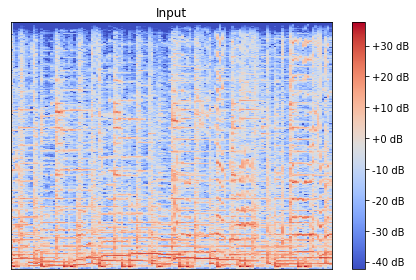

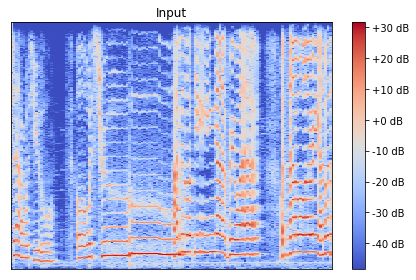

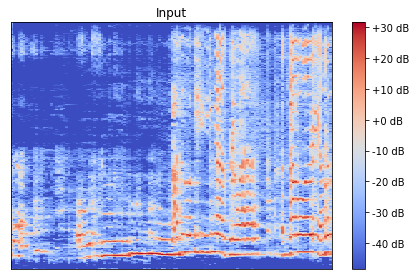

In [51]:
ix = 121

S_in = np.squeeze(X_[ix]) * V[ix]
show_spectrogram(S_in)

S = np.squeeze(Y_[ix]) * W[ix]
show_spectrogram(S)

S_pred = unet.predict(X_[ix:ix+1])
S_pred = np.squeeze(S_pred) * V[ix]
show_spectrogram(S_pred)

In [52]:
spectrogram_to_wavfile(f'S_in_{ix}.wav', S_in)
spectrogram_to_wavfile(f'S_targ_{ix}.wav', S)
spectrogram_to_wavfile(f'S_pred_{ix}.wav', S_pred)

Inverting spectrogram...
Creating S_in_121.wav...
Done
Inverting spectrogram...
Creating S_targ_121.wav...
Done
Inverting spectrogram...
Creating S_pred_121.wav...
Done
